#Lecture 14: Advanced MCMC Methods

AM207: Pavlos Protopapas, Harvard University

March 7 2014


------


# Parallel Tempering

Parallel Tempering is a MCMC sampling technique that allows us to generate samples from a distribution, $p(x)$, which we cannot take the inverse  analytically -usual arguments go here.

The general idea of parallel tempering is to simulate $N$ replicas of the original system of interest (in our case, a single Metropolis Hastings chain), each replica at a different temperature. The temperature of a Metropolis Hastings Markov Chain defines how likely it is to sample from a low-density part of the target distribution. The high temperature systems are generally able to sample large volumes of phase space, whereas low temperature systems, while having precise sampling in a local region of phase space, may become trapped in local energy minima. Parallel tempering achieves good sampling by allowing the systems at different temperatures to exchange complete configurations. Thus, the inclusion of higher temperature systems ensures that the lower temperature systems can access a representative set of low-temperature regions of phase space.

There are $N$ replicas each at different temperatures $T_i$ that produce $n$ samples each before possibly swapping states.

Recall that the way to reflect a temperature's effect on the sampling is to change $p(x)$ with respect to the temperature $T$ such that

$$p_{new}(x) = e^{-\frac{1}{T} \log{p(x)}}$$

Note that a higher value of $T$ will 'flatten' the target distribution increasing the chance of acceptance.

The probability of swapping any two instances of $M$ replicas is given by

$$A = min\left(1, \frac{p_k(x_{k+1})P_{k+1}(x_k)}{p_k(x_k) p_{k+1}(x_{k+1})}\right)$$

One of the $T_i$ is always set to 1 and this is the only replica that we use as output of the Parallel tempering algorithm. It may seem like a waste to throw away the other simulations, but depending on the target distribution, the extra accuracy is up to six fold greater.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
from IPython import display

### Example

Let's go through an excercise to see how parallel tempering can prove to be more robust than the vanilla Metropolis Hastings algorithm.

With multi-peaked probability functions, vanilla Metropolis Hastings has to deal with a temperature that is is too wide ( which reduces accuracy) and narrow (which leaves it susceptible to getting stuck in regions within the sample space and not traversing a gap between peaks).

Let us try to illustrate this using the function, 

$$f(x) = \sin(30x)+1$$

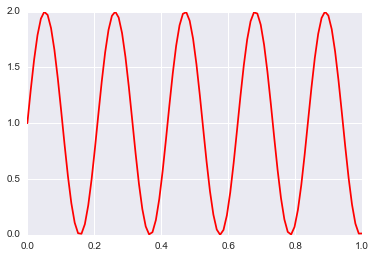

In [3]:
## FUNCTIONS 
# target distribution p(x) 
p = lambda x: np.sin(x*30)+1

xx= np.linspace(0,1,100)
plt.plot(xx,p(xx), 'r', label=u'True dsitribution')
plt.show()

Now, let's run our vanilla Metropolis Hastings algorithm to sample from $p(x)$

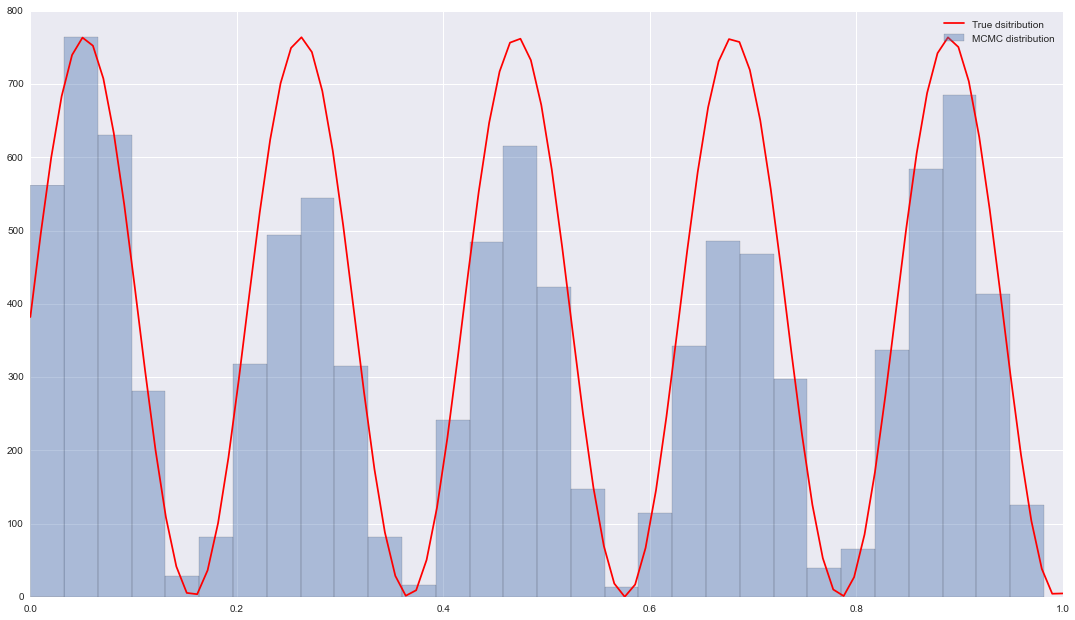

In [5]:
# number of samples
n = 10000
sig =0.05


#intitialize the sampling. Start somewhere from 0..1
x0 = np.random.uniform()

#create a simple Metropolis Hastings function
def MH_simple(p, n, sig, x0):
    x_prev = x0
    x=[]
    k=1
    i=0
    while i<n:
        
        x_star = np.random.normal(x_prev, sig)
        
        
        
        P_star = p(x_star)
        P_prev = p(x_prev)
        U =  np.random.uniform()
        
        A =  P_star/P_prev
        if U < A and (x_star > 0) and (x_star < 1):
            x.append(x_star)
            i = i + 1
            x_prev = x_star
        else :
            x.append(x_prev)
            x_prev = x[i]  
            i = i + 1
     
            k=k+1
    return x

x = MH_simple(p, n, sig, x0)


e,q,h=plt.hist(x,30, alpha=0.4, label=u'MCMC distribution')


xx= np.linspace(0,1,100)
plt.plot(xx,np.max(e)*p(xx)/np.max(p(xx)), 'r', label=u'True dsitribution')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

Compare this with Parallel Tempering:

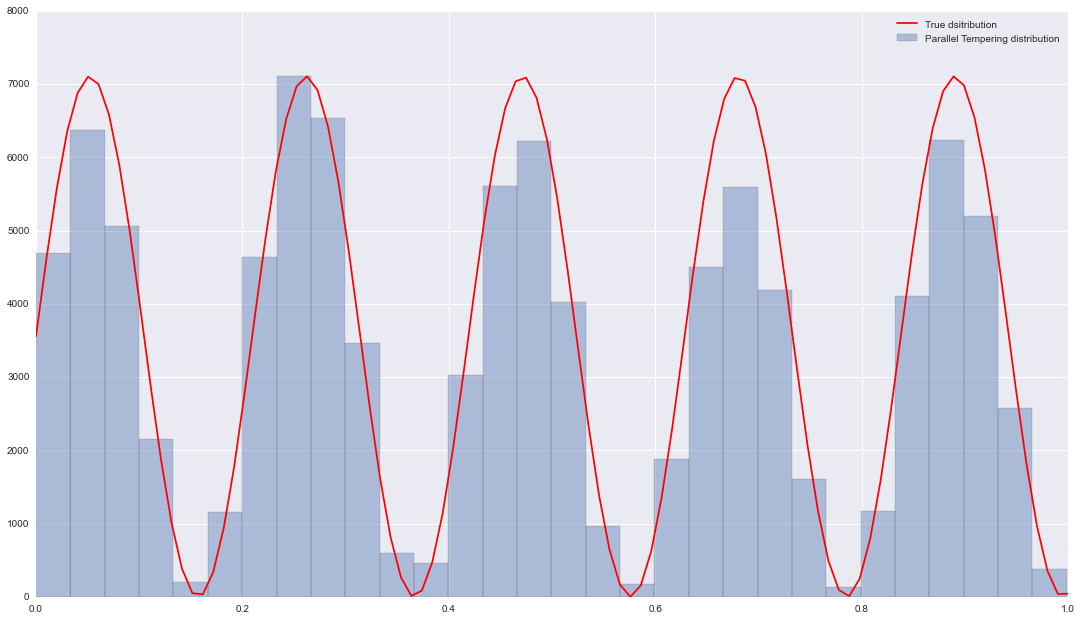

In [6]:
import math
# parallel tempering

# p is the target probability distribution, X0s is a list of initalizations for each chain
# Ts is a list of temperatures, n is the number of samples taken per sweep, N is the number of sweeps
def PT_simple(p, Ts, n, N):
    
    num_chains = len(Ts)
    
    #create temperature-influenced distributions
    Ps = []
    for chain in range(num_chains):
        Ps.append(lambda x, chain=chain: math.exp(float(1/Ts[chain])*math.log(p(x))))
    
    X0s = [np.random.uniform() for i in range(num_chains)]
    
    x=[ [] for i in range(num_chains)]
    for sweep in xrange(N):
        for chain in range(num_chains):
            x[chain] = x[chain] + MH_simple(Ps[chain], n, .05, X0s[chain])    #AUGMENTING MORE SAMPLES IN THE CHAIN
        for chain in range(num_chains-1):
            x1 = x[chain][-1]
            x2 = x[chain+1][-1]
            A = (Ps[chain](x2)*Ps[chain+1](x1))/(Ps[chain](x1)*Ps[chain+1](x2)) # ACCEPTANCE PROBABILITY 
            if np.random.uniform() < A:
                X0s[chain] = x2
                X0s[chain+1] = x1
                x[chain] = x[chain] + [x2]
                x[chain+1] = x[chain+1] + [x1]
            else:
                X0s[chain] = x1
                X0s[chain+1] = x2 
                x[chain] = x[chain] + [x1]
                x[chain+1] = x[chain+1] + [x2]

    # return a flattened list
    return x[0]

x = PT_simple(p, [1,5,10], 1000, 100)

e,q,h=plt.hist(x,30, alpha=0.4, label=u'Parallel Tempering distribution')


xx= np.linspace(0,1,100)
plt.plot(xx,np.max(e)*p(xx)/np.max(p(xx)), 'r', label=u'True dsitribution')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

As you can see, the Parallel Tempering implementation produced a much more accurate sampling from this muli-peaked distribution. 

### Example 2. Multidimensional example
Sample from the function
$$ p(x,y) = \exp^{ -\frac{(x-y)^2}{2\,\sigma^2}}+\exp^{-\frac{(x+0.3)^2}{0.01}}\exp^{-\frac{(y-0.3)^2}{0.01}}$$

In [7]:
## FUNCTIONS 
# target distribution p(x) 
ee=0.01
p = lambda x,y: np.exp(-(x-y)**2 / (2*ee) - (x+y)**2/2) + np.exp( -(x+.30)**2/0.01)*np.exp( -(y-.30)**2/0.01)
Ps = lambda x,y: math.exp(float(1.0/Ts[chain])*math.log(p(x,y)))
xx= np.linspace(-1,1,100)
yy= np.linspace(-1,1,100)

M = np.empty((100,100))
i=0
for x in xx:
    j=0
    for y in yy:
        M[j,i]=p(x,y)
        j +=1
    i +=1


In [20]:
plt.figure(figsize=[12,8])

# METROPOLIS ALGORITHM 
# number of samples
n = 1000
sig =.05



#create a simple Metropolis Hastings function
def MH_simple2(p, n, sig, T, x0, y0):
    x_prev = x0
    y_prev = y0
    x=[]; y=[]
    k=1
    i=0

    
    while i<n:
        
        x_star = np.random.normal(x_prev, sig)
        y_star = np.random.normal(y_prev, sig)
        
        
        P_star = p(x_star, y_star)
        P_prev = p(x_prev, y_prev)
        U =  np.random.uniform()
        
        E_star = -np.log(P_star)
        E_prev = -np.log(P_prev)
        
        A =  np.exp(-(1.0/T) * (E_star-E_prev))
        if U < A:
            x.append(x_star); y.append(y_star); 
            i = i + 1
            x_prev = x_star; y_prev = y_star
        else :
            x.append(x_prev); y.append(y_prev); 
            x_prev = x[i] ; y_prev = y[i]  
            i = i + 1
     
            k=k+1
    return x,y,k


#intitialize the sampling. Start somewhere from 0..1
x0 = np.random.uniform(low=-1, high=1)
y0 = np.random.uniform(low=-1, high=1)

T=1
xL,yL, k = MH_simple2(p, n, sig, T, x0, y0)
print k

x0 = np.random.uniform(low=-1, high=1)
y0 = np.random.uniform(low=-1, high=1)

T=50.0
xH,yH, k = MH_simple2(p, n, sig, T, x0, y0)
print k


349
29


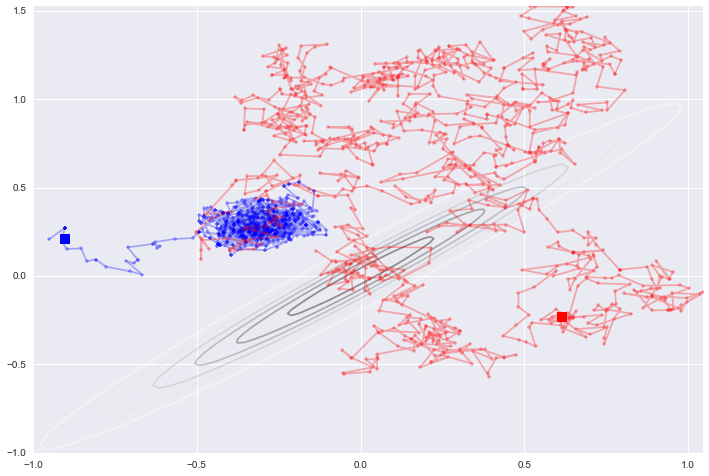

In [21]:
plt.figure(figsize=[12,8])
plt.contour(xx,yy,M, alpha=0.4)
plt.plot(xL,yL, 'b.-', alpha=0.3)
plt.plot(xL[1],yL[0], 'bs', ms=10)
plt.plot(xH,yH, 'r.-', alpha=0.3)
plt.plot(xH[1],yH[0], 'rs', ms=10)

In [34]:
Ts = [1.0, 5.0] #[0.01, 0.1, 1, 10]
n=10  # 
N= 2 # 
sig =.05
num_chains = len(Ts)
eps= 0.00001
  
#create temperature-influenced distributions
Ps = []
for chain in range(num_chains):
    Ps.append(lambda x=x,y=y,chain=chain: math.exp(float(1.0/Ts[chain])*math.log(p(x,y)+0.00001)))
#    print "BL:AH", chain, Ps[chain](0.2,0.1)
#print len(Ps),"BL:AH-0", Ps[0](0.2,0.1), Ps[1](0.2,0.1)


#Ps=[]
#Ps.append(lambda x=x,y=y: math.exp(float(1.0/Ts[chain-1])*math.log(p(x,y)+0.00001)))
#Ps.append(lambda x=x,y=y: math.exp(float(1.0/Ts[chain])*math.log(p(x,y)+0.000001)))
#print len(Ps), Ts
#print "BLAH2", Ps[0](0.2,0.1), Ps[1](0.2,0.1)

X0s=np.random.uniform(low=-.1, high=.1, size=num_chains)
Y0s=np.random.uniform(low=-.1, high=.1, size=num_chains)

x=[ [] for i in range(num_chains)]
y=[ [] for i in range(num_chains)]
for sweep in xrange(N):
    for chain in range(num_chains):
        x[chain] = x[chain] + MH_simple2(Ps[chain], n, sig, Ts[chain], X0s[chain],Y0s[chain])[0]    #AUGMENTING MORE SAMPLES IN THE CHAIN
        y[chain] = y[chain] + MH_simple2(Ps[chain], n, sig, Ts[chain], X0s[chain],Y0s[chain])[1]
    for chain in range(num_chains-1):
        x1 = x[chain][-1]
        y1 = y[chain][-1]
        x2 = x[chain+1][-1]
        y2 = y[chain+1][-1]
        A = Ps[chain](x2,y2)*Ps[chain+1](x1,y1)/(Ps[chain](x1,y1)*Ps[chain+1](x2,y2)+eps)  # ACCEPTANCE PROBABILITY 
        rn=np.random.uniform()
        if rn < A:
            X0s[chain] = x2
            X0s[chain+1] = x1
            Y0s[chain] = y2
            Y0s[chain+1] = y1
            x[chain] = x[chain] + [x2]
            x[chain+1] = x[chain+1] + [x1]
            y[chain] = y[chain] + [y2]
            y[chain+1] = y[chain+1] + [y1]
            print "YES"
        else:
            X0s[chain] = x1
            X0s[chain+1] = x2
            Y0s[chain] = y1
            Y0s[chain+1] = y2
            x[chain] = x[chain] + [x1]
            x[chain+1] = x[chain+1] + [x2]
            y[chain] = y[chain] + [y1]
            y[chain+1] = y[chain+1] + [y2]

# return a flattened list
#return x[0]

YES


In [32]:
#math.exp(float(1.0/Ts[1])*math.log(p(x1,y1))+0.000001)


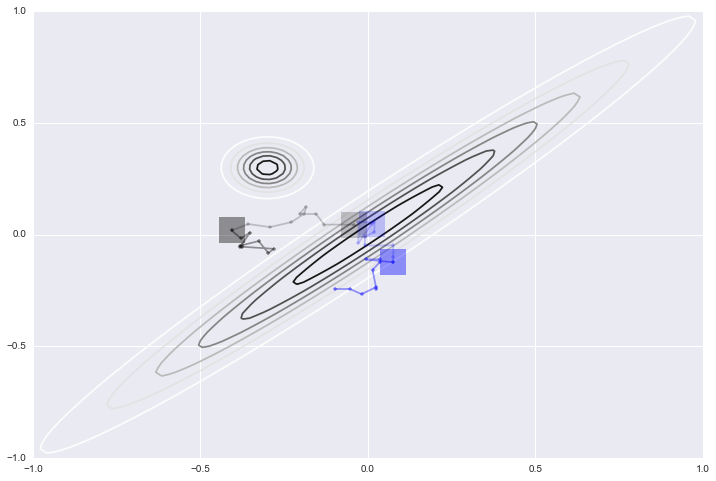

In [35]:
plt.figure(figsize=[12,8])
plt.contour(xx,yy,M, alpha=0.9)

for k in np.arange(0,N):



    plt.plot(x[0][k*n],y[0][k*n], 'bs', alpha=0.2*(k+1),ms=26)
    plt.plot(x[0][k*n:(k+1)*n],y[0][k*n:(k+1)*n], 'b.-', alpha=0.2*(k+1))
    
    plt.plot(x[1][k*n],y[1][k*n], 'ks',alpha=0.2*(k+1), ms=26)
    plt.plot(x[1][k*n:(k+1)*n],y[1][k*n:(k+1)*n], 'k.-', alpha=0.2*(k+1))
    

    
    #plt.plot(x[2][0],y[2][0], 'rs', ms=10)
    #plt.plot(x[2][k*n:(k+1)*n],y[2][k*n:(k+1)*n], 'r.-', alpha=0.1*(k+1))
    
    #plt.plot(x[3][0],y[3][0], 'ys', ms=10)
    #plt.plot(x[3][k*n:(k+1)*n],y[3][k*n:(k+1)*n], 'y.-', alpha=0.03*(k+1))

<matplotlib.contour.QuadContourSet instance at 0x10d1b64d0>

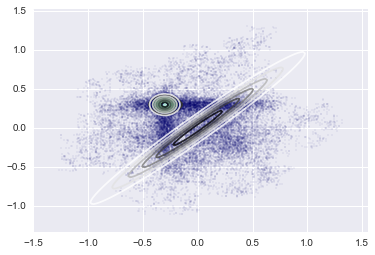

In [401]:
sns.kdeplot(np.array(x[0]), np.array(y[0]))
plt.scatter(x[0][1000:], y[0][1000:], alpha=0.1, s=1.0)

plt.contour(xx,yy,M, alpha=0.8)

# Emcee

Emcee is an algorithm based on Goodman and Weare's paper on Ensemble Samplers with Affine Invarience. The advantage is that the performance of these samplers is unaffected by afﬁne tranformations of space. 

Each step in a MH chain is proposed using a  proposal distribution centered on the current position of
the chain (normally a multivariate Gaussian or something similar). Since each term in the
covariance matrix of this proposal distribution is an unspecified parameter, this method has
$N [N +1]/2$ tuning parameters (where N is the dimension of the parameter space). To make
matters worse, the performance of this sampler is very sensitive to these tuning parameters
and there is no fool-proof method for choosing the values correctly. 


Goodman and Weare introduced the concept of affine invariant MCMC samplers.  To understand the motivation behind their introduction, let's look at a particular anisotropic density similar to the one we have above but unimodal:

$$p(x_1,x_2)  \propto \exp \left( -\frac{ (x_1-x_2)^2}{2 \epsilon} - \frac{(x_1+x_2)^2}{2} \right)$$


This density would be considered difficult (in the small-$\epsilon$ regime) for standard MCMC algorithms.
In principle, it is possible to tune the hyperparameters of a MH sampler to make this
sampling converge quickly, but if the dimension is large and calculating the density is computationally expensive the tuning procedure becomes very difficult (and also isn't particularly generalizeable).

However, it's possible to use the following affine transformation to generate a set of variables: 

$$y_1=\frac{ x_1-x_2}{\sqrt{\epsilon}}$$  $$y_2=x_1+x_2$$


which yields a transformed distribution

$$p(y_1, y_2) \propto e^{-(y_1^2+y_2^2)/2} $$

that would be unproblematic to sample using the normal metropolis hastings algorithm.

<matplotlib.contour.QuadContourSet instance at 0x109cffcb0>

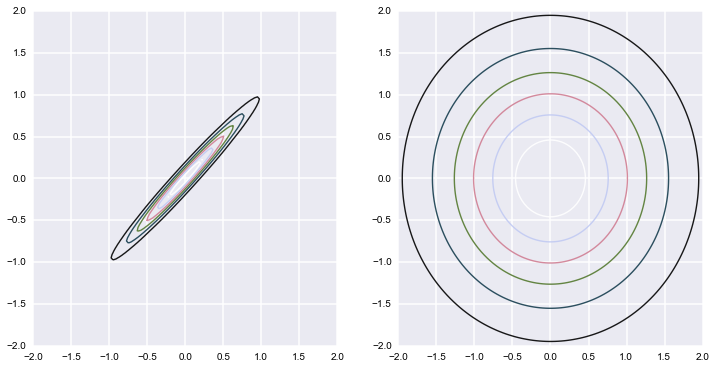

In [47]:
p2 = lambda x,y: np.exp(-(x-y)**2 / (2*ee) - (x+y)**2/2)
paf = lambda x,y: np.exp(-(x**2+y**2) / (2) )

xx= np.linspace(-2,2,100)
yy= np.linspace(-2,2,100)

M = np.empty((100,100))
Maf = np.empty((100,100))
i=0
for x in xx:
    j=0
    for y in yy:
        M[j,i]=p2(x,y)
        Maf[j,i]=paf(x,y)
        j +=1
    i +=1

plt.figure(figsize=[12,6])

plt.subplot(1,2,1)
plt.contour(xx,yy,M, alpha=0.9)


plt.subplot(1,2,2)
plt.contour(xx,yy,Maf, alpha=0.9)

The basic idea, is that an algorithm that is affine invariant performs equally
well computationally under all affine transformations of your variable space; since covariance matrices are affine transformations of each one another, it will therefore be insensitive to covariances among
parameters. Sampling the well scaled transformed density does not require detailed customization.
An affine invariant sampler views the two densities as equally difficult.
In particular, the performance of an affine invariant scheme on the skewed density above
 is independent of $\epsilon$. 

The goal is therefore to create an affine sampler. 

We call such an MCMC algorithm affine invariant if, for any affine transformation Ax Cb,


The algorithm is easy to use and requires little or no additional computational overhead. It is particularly useful for sampling badly scaled distributions. Computational tests show that the afﬁne invariant methods can be signiﬁcantly faster than standardn MCMC methods on highly skewed distributions.


The key reason why Emcee outpreforms other MCMC methods on sampling certain target distributions is because of its affine invarience property. An afﬁne transformation is an invertible mapping from $R^n$ to $R^n$ $y = Ax + B$  (i.e. a linear transformation and a translation). If X has probability density $\pi(x)$, then $y= Ax + B$ has density:

$\pi_{A,B} = \pi_{A,B}(Ax+B)$  $\alpha$ $\pi(x)$

Let's say that given a distribution $\pi(x)$ and a set of i.i.d. random variables $\xi$ a sampler produces after $t$ iterations a set of samples $ \{X^1, X^2, ... X^t\}$.  That sampler would be called affine invariant if under any affine transformation $X \rightarrow AX+b$ and the sampler with the same set of i.i.d. random variables $\xi$ after $t$ iterations produces a set of samples $\{Y^1, Y^2, ... Y^t\}$ and each $Y_j = AX_j + b$.  If this is the case our procedure for producing samples will construct the correct samples in approximately the same computational time regardless affine transformations and that is the goal of our endeavor.

How do we go about constructing an affine invariant sampler?  In the Goodman and Weare scheme, we adapt the metropolis hastings proposal to be affine.  Goodman and Weare propose three such proposal moves  -- the stretch move, walk move, and replace move. We'll focus on the stretch move.


Before we get to the stretch move, let's look at the ensemble nature of Goodman and Weare's sampler.  We've touched on parallelization of MCMC in the past.  We discussed that since every step of metropolis hastings is depends on previous steps making it hard to parallelize, one approach to parallelization is to launch multiple independent chains simultaneously. If we have $L$  chains that are independent, it's not hard to see that that the joint probability density of the ensemble factors to the target distribution we seek.

$$ \Pi(\vec{x}) = \Pi(x_1, \dots, x_L) = \pi(x_1)\pi(x_2)\dots\pi(x_L) $$

However, the ensemble Markov chain can preserve the product density without the individual walker sequences being independent, or even being Markov as long as the distribution of a given chain $ X_k $ at iteration $t+1$ depends only on other chains $X_j$ at iteration $t$ i.e.

$$ X^{t+1}_k = f(\{X^t_{j\neq k}\}) $$

So as long as we have an invariant update step, we'll be in business.  Let
How does Emcee work? It's actually quite simple in that it's an ensemble method whereby some each oneof the $N$ walkers are updated using Metropolis Hastings criteria with respect partial resampling of the positions of all other walkers in the emnsemble. The updates occur in the most basic form, 

$$X_k(t) -> Y = X_j + Z(X_k(t) -X_j)$$

where $X_j$ is a single complementary walker in the ensemble, and $X_k -> Y $ is the proposal distribution. 

Read more about it here: http://msp.org/camcos/2010/5-1/camcos-v5-n1-p04-s.pdf

## Example of Emcee Algorithm

('Mean acceptance fraction:', 0.19055600000000011)


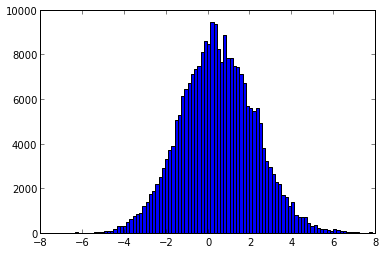

In [10]:
import numpy as np
import emcee

# First, define the probability distribution that you would like to sample.
def lnprob(x, mu, icov):
    diff = x-mu
    return -np.dot(diff,np.dot(icov,diff))/2.0

# We'll sample a 50-dimensional Gaussian...
ndim = 50
# ...with randomly chosen mean position...
means = np.random.rand(ndim)
# ...and a positive definite, non-trivial covariance matrix.
cov  = 0.5-np.random.rand(ndim**2).reshape((ndim, ndim))
cov  = np.triu(cov)
cov += cov.T - np.diag(cov.diagonal())
cov  = np.dot(cov,cov)

# Invert the covariance matrix first.
icov = np.linalg.inv(cov)

# We'll sample with 250 walkers.
nwalkers = 250

# Choose an initial set of positions for the walkers.
p0 = [np.random.rand(ndim) for i in xrange(nwalkers)]

# Initialize the sampler with the chosen specs.
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[means, icov])

# Run 100 steps as a burn-in.
pos, prob, state = sampler.run_mcmc(p0, 100)

# Reset the chain to remove the burn-in samples.
sampler.reset()

# Starting from the final position in the burn-in chain, sample for 1000
# steps.
sampler.run_mcmc(pos, 1000, rstate0=state)

# Print out the mean acceptance fraction. In general, acceptance_fraction
# has an entry for each walker so, in this case, it is a 250-dimensional
# vector.
print("Mean acceptance fraction:", np.mean(sampler.acceptance_fraction))

# plot the first dimension of each of our sampled points
hist(sampler.flatchain[:,0], 100)
show()

# MultiNest

MultiNest is another MCMC algorithm which is based on Nested Sampling.

Nested Sampling is a simple but powerful alternative to traditional annealing in the Metropolis Hastings sampling algorithm. The basic idea of Nested Sampling is to sample the posterior space with a number of active points (model parameters) drawn from the prior. Points with the lowest likelihood are then iteratively replaced with points of strictly higher likelihood (also drawn from the prior). In doing so, one shrinks the "prior volume" with each iteration, hence the algorithm is called "nested".

Recall that in traditional annealing, with temperature $t$, $x_star$ is accepted iff $p_{t}(x_star) > p_{t}(x_prev) \times U(0,1). The system is periodically reheated as it cools.

In Nested Sampling, $x_{star}$ is accepted iff $p(x_{star}) \ge p^*$. Periodically, $p^*$ gets reset to the  lowest  of  an  ensemble  of $n$
such  points. The  method requires  to  sample  uniformly  from  the  fraction  of  the  prior  volume $p(x)$ above  the iso-likelihood level
$p^*$.

MultiNest is a tuned Nested Sampling algorithm thats an extremely efficient sampler for highly challenging multi-modal likelihoods.

### Pseudocode

Draw N points from prior

Compute likelihood for each point

Do:

    Select point, $x_{prev}$ with lowest likelihood value, $p^*$
    
    Replace with a point $X_{star}$ drawn from prior with constraint $p(x_{star}) > p^*$
    
    Save x_{prev}
    
    if $max(p(x))$ < tolerance, exit

There is a package availible called pyMultiNest which is easy to use and allows you to take advantage of the power of nested sampling: http://johannesbuchner.github.io/PyMultiNest/